In [ ]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import wandb
from google.colab import files
from torch.utils.data import DataLoader

uploaded = files.upload()

project_root = Path.cwd()
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from musicagent.config import OnlineConfig
from musicagent.data import OnlineDataset, make_online_collate_fn
from musicagent.models import OnlineTransformer
from musicagent.utils import load_configs_from_dir, compute_adaptation_dynamics

# Evaluation - now using the unified evaluate_online function
from musicagent.eval import evaluate_online, OnlineEvalResult, note_in_chord_ratio


Saving realchords_data.tar.gz to realchords_data.tar.gz


In [ ]:
%cd /content/models

wandb.login()
ARTIFACT_REF = "marty1ai/musicagent/best-online-model:v43"

CHECKPOINT_DIR = Path("checkpoints")
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

api = wandb.Api()
artifact = api.artifact(ARTIFACT_REF, type="model")
artifact_dir = Path(artifact.download(root=str(CHECKPOINT_DIR)))
CHECKPOINT_PATH = artifact_dir / "best_model.pt"
print(f"Artifact downloaded to: {artifact_dir}")


/content/models


wandb: Downloading large artifact 'best-online-model:v43', 147.98MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:01.7 (85.9MB/s)


checkpoints/best_model.pt


In [ ]:
# Evaluation config
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAMPLE = False
TEMPERATURE = 1.0

# Load configs from wandb artifact
d_cfg, m_cfg = load_configs_from_dir(artifact_dir, OnlineConfig)

m_cfg.device = DEVICE
device = torch.device(m_cfg.device)
print(f"Device: {device}")

# Use OnlineDataset - filters zero-frame sequences and provides correct interleaved format
test_ds = OnlineDataset(d_cfg, split="test")
collate_fn = make_online_collate_fn(pad_id=d_cfg.pad_id)
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
)

# Vocab mappings for decoding
# OnlineDataset uses unified vocab: melody [0, melody_vocab_size), chord offset by melody_vocab_size
id_to_melody = {v: k for k, v in test_ds.vocab_melody.items()}
id_to_chord = {v: k for k, v in test_ds.vocab_chord.items()}
melody_vocab_size = test_ds.melody_vocab_size
chord_vocab_size = test_ds.chord_vocab_size

# Model
model = OnlineTransformer(m_cfg, d_cfg, melody_vocab_size, chord_vocab_size).to(device)
state = torch.load(CHECKPOINT_PATH, map_location=device, weights_only=True)
model.load_state_dict(state)
model.eval()

print(f"\nModel loaded: {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Melody vocab: {melody_vocab_size}, Chord vocab: {chord_vocab_size}")
print(f"Test set: {len(test_ds)} sequences (after filtering zero-frame)")


Device: cuda


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



Model loaded: 38,520,496 parameters
Melody vocab: 204, Chord vocab: 12772


In [ ]:
# Run evaluation
result: OnlineEvalResult = evaluate_online(
    model=model,
    test_loader=test_loader,
    d_cfg=d_cfg,
    id_to_melody=id_to_melody,
    id_to_chord=id_to_chord,
    melody_vocab_size=melody_vocab_size,
    device=device,
    temperature=TEMPERATURE,
    sample=SAMPLE,
)

# Extract results for visualization cells
cached_predictions = result.cached_predictions
avg_nic = result.nic_ratio
std_nic = result.nic_std
all_pred_lengths = result.pred_lengths
all_ref_lengths = result.ref_lengths

print(f"\n{'='*50}")
print("Results (sample-mean NiC, per paper Section K)")
print(f"{'='*50}")
print(f"NiC Ratio:            {avg_nic * 100:.2f}% ± {std_nic * 100:.2f}%")
print(f"Onset Interval EMD:   {result.onset_interval_emd * 1e3:.2f} × 10⁻³")
print(f"Chord Length Entropy: {result.pred_entropy:.2f} (ref: {result.ref_entropy:.2f})")
print(f"Total sequences:      {result.num_sequences:,}")

Evaluating 87 batches...
  Processed 10/87 batches
  Processed 20/87 batches
  Processed 30/87 batches
  Processed 40/87 batches
  Processed 50/87 batches
  Processed 60/87 batches
  Processed 70/87 batches
  Processed 80/87 batches
  Processed 87/87 batches
NiC Ratio:         7.75%
Onset Interval EMD:          945.61 × 10⁻³
Chord Length Entropy (pred): 0.90
Chord Length Entropy (ref):  2.30


In [ ]:
# Adaptation dynamics
MIN_SAMPLES_PER_BEAT = 10

dynamics = compute_adaptation_dynamics(
    cached_predictions,
    max_beats=64,
    frame_rate=4,  # 16th notes
    min_samples=MIN_SAMPLES_PER_BEAT,
)

# Extract for plotting
valid_beats = dynamics.valid_beats
beat_means = dynamics.beat_means
beat_stds = dynamics.beat_stds

if valid_beats:
    print(f"Computed dynamics for beats 0-{max(valid_beats)} ({len(valid_beats)} beats with ≥{MIN_SAMPLES_PER_BEAT} samples)")
    print(f"Beat 0 NiC: {beat_means[0]*100:.1f}% (n={dynamics.samples_per_beat[0]})")
    if len(valid_beats) > 1:
        print(f"Beat {valid_beats[-1]} NiC: {beat_means[-1]*100:.1f}% (n={dynamics.samples_per_beat[valid_beats[-1]]})")
else:
    print(f"⚠ No beats had ≥{MIN_SAMPLES_PER_BEAT} non-silent samples.")

Analyzing adaptation dynamics on 100 samples...
  Processed 25/100 samples
  Processed 50/100 samples
  Processed 75/100 samples
  Processed 100/100 samples

Computed dynamics for beats 0-0


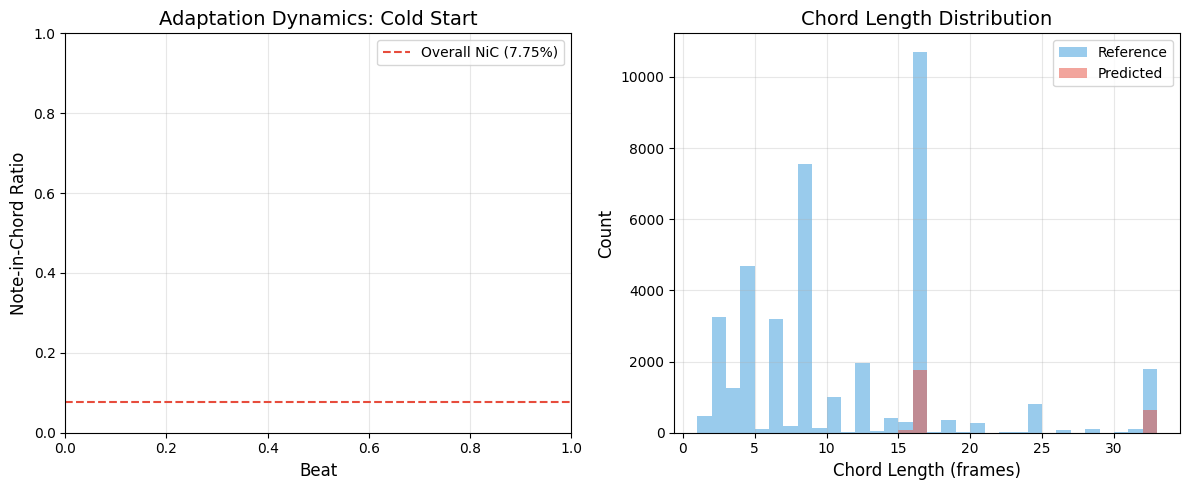

In [ ]:
plt.figure(figsize=(14, 5))

# Adaptation dynamics (Figure 4 style)
plt.subplot(1, 2, 1)
if valid_beats:
    plt.plot(valid_beats, beat_means, 'o-', color='#2ecc71', linewidth=2, markersize=4, label='Online Model')
    plt.fill_between(
        valid_beats,
        [m - s for m, s in zip(beat_means, beat_stds)],
        [m + s for m, s in zip(beat_means, beat_stds)],
        alpha=0.2, color='#2ecc71'
    )
plt.axhline(y=avg_nic, color='#e74c3c', linestyle='--', linewidth=2, label=f'Overall NiC ({avg_nic:.1%})')
plt.xlabel('Beat', fontsize=12)
plt.ylabel('Note-in-Chord Ratio', fontsize=12)
plt.title('Adaptation Dynamics: Cold Start', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.xlim(0, max(valid_beats) if valid_beats else 32)

# Chord length histogram
plt.subplot(1, 2, 2)
max_len = 32
pred_hist = [min(length, max_len) for length in all_pred_lengths]
ref_hist = [min(length, max_len) for length in all_ref_lengths]

plt.hist(ref_hist, bins=range(1, max_len + 2), alpha=0.6, label='Reference', color='#3498db', edgecolor='white')
plt.hist(pred_hist, bins=range(1, max_len + 2), alpha=0.6, label='Predicted', color='#e74c3c', edgecolor='white')
plt.xlabel('Chord Length (frames)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Chord Length Distribution', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
def show_example(idx: int, max_frames: int = 48):
    """Display a single example generation using cached predictions."""
    if idx not in cached_predictions:
        print(f"⚠ Example {idx} not in cache. Skipping.")
        return

    mel_tokens, pred_tokens, ref_tokens = cached_predictions[idx]
    nic = note_in_chord_ratio(mel_tokens, pred_tokens)

    def format_tokens(tokens, max_n):
        """Format tokens for display, filtering special tokens."""
        filtered = [t for t in tokens[:max_n] if not t.startswith('<')]
        if not filtered:
            return "(all rest/special tokens)"
        # Simplify display: remove _on/_hold suffixes, compress holds
        display = []
        for t in filtered:
            if t.endswith('_hold') and display and display[-1] == '...':
                continue
            elif t.endswith('_hold'):
                display.append('...')
            else:
                display.append(t.replace('_on', ''))
        return ' '.join(display[:24])  # Limit width

    print(f"\n{'='*70}")
    print(f"Example {idx} | NiC: {nic:.1%} | Frames: {len(mel_tokens)}")
    print(f"{'='*70}")
    print("\nMelody:")
    print(format_tokens(mel_tokens, max_frames))
    print("\nPredicted Chords:")
    print(format_tokens(pred_tokens, max_frames))
    print("\nReference Chords:")
    print(format_tokens(ref_tokens, max_frames))

# Show examples: best, median, worst by NiC
if cached_predictions:
    sorted_by_nic = sorted(
        cached_predictions.keys(),
        key=lambda idx: note_in_chord_ratio(
            cached_predictions[idx][0], cached_predictions[idx][1]
        ),
        reverse=True
    )

    print("Showing examples by NiC quality (best, median, worst):")
    show_example(sorted_by_nic[0])  # Best
    show_example(sorted_by_nic[len(sorted_by_nic) // 2])  # Median
    show_example(sorted_by_nic[-1])  # Worst



Example 0 | NiC: 0.00%

Melody (first 32 frames):
<pad> <pad>

Predicted Chords:
rest rest

Reference Chords:


Example 50 | NiC: 0.00%

Melody (first 32 frames):
<pad> <pad>

Predicted Chords:
rest rest

Reference Chords:


Example 100 | NiC: 0.00%

Melody (first 32 frames):
<pad> <pad>

Predicted Chords:
rest rest

Reference Chords:

